In [43]:
# Import libraries
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as Lin_Reg, RidgeCV, LassoCV, ElasticNetCV, LogisticRegressionCV, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

In [44]:
# Turns on feature selection using Lasso Regularized Linear Regression
turn_on_feature_selection = False

In [45]:
# Load training and test sets (assumes you have these in current working directory)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [46]:
columns = []
for column in train.columns:
    if train[column].mean() > 0 and train[column].astype(bool).sum(axis=0) > 50:
        columns.append(column)
train = train[columns]
test = test[columns[:-1]]
len(columns)

139

In [47]:
for column in train.columns:
    if column != 'Target' and column != 'Id':
        train[column] = (train[column] - train[column].mean())/train[column].std()
        test[column] = (test[column] - train[column].mean())/train[column].std()

In [48]:
# Inspect training set
train.head()

,Id,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 233,Feat 235,Feat 243,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251,Target
0,1,0.036994,0.490623,0.030325,0.025409,0.321197,0.212749,-0.379634,-0.244819,-0.498569,...,-0.246801,-0.209258,-0.097279,0.508485,-0.587196,0.337471,-0.042821,0.737673,0.207387,0.901355
1,2,0.077917,0.490623,0.041357,0.066135,0.321197,-0.522044,-0.379634,-0.244819,-0.498569,...,-0.246801,-0.209258,-0.097279,0.938625,-0.038153,1.041111,0.234478,-0.095843,0.043520,0.913550
2,3,0.020973,-2.215483,-0.152083,0.016527,-0.926845,0.580139,1.306890,-0.244819,-0.498569,...,-0.246801,-0.209258,-0.097279,-2.069707,4.075270,-1.680660,-1.008981,0.080658,-1.684347,0.884824
3,4,0.092361,0.490623,-0.085796,0.082058,1.569248,0.212749,1.306890,-0.244819,-0.498569,...,-0.246801,-0.209258,-0.097279,1.055695,-0.033121,0.302676,1.669759,2.071695,0.973325,0.977236
4,5,-0.018954,0.490623,-0.042975,0.012843,0.945222,-0.522044,-0.379634,-0.244819,-0.498569,...,-0.246801,-0.209258,-0.097279,-0.897240,-0.416328,-0.907430,-1.232109,0.113991,-1.187867,0.921138


In [49]:
train.describe()

,Id,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 233,Feat 235,Feat 243,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251,Target
count,5331.000000,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,...,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5.331000e+03,5331.000000
mean,2666.000000,1.835002e-14,3.498733e-17,-1.586692e-14,-6.167434e-15,-1.332851e-16,-2.132561e-17,-6.664254e-18,-3.198842e-17,5.264760e-17,...,-3.465412e-17,3.998552e-18,-7.997105e-18,-2.385803e-16,8.130390e-17,-5.331403e-18,5.597973e-17,3.432091e-17,3.758639e-16,0.919657
std,1539.071473,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.027995
min,1.000000,-5.950247e+01,-2.215483e+00,-6.735294e+01,-6.553534e+01,-9.268450e-01,-5.220443e-01,-3.796340e-01,-2.448187e-01,-4.985687e-01,...,-2.468008e-01,-2.092579e-01,-9.727892e-02,-2.956599e+00,-8.912429e-01,-1.680660e+00,-2.174746e+00,-1.431602e+00,-3.809069e+00,0.845348
25%,1333.500000,2.927390e-02,3.443441e-01,-4.222706e-02,2.027728e-02,-9.268450e-01,-5.220443e-01,-3.796340e-01,-2.448187e-01,-4.985687e-01,...,-2.468008e-01,-2.092579e-01,-9.727892e-02,-2.959279e-01,-5.884485e-01,-6.483976e-01,-7.004807e-01,-6.693855e-01,-6.233486e-01,0.903749
50%,2666.000000,8.887454e-02,3.809139e-01,6.510478e-02,4.389721e-02,-3.028195e-01,-5.220443e-01,-3.796340e-01,-2.448187e-01,-4.985687e-01,...,-2.468008e-01,-2.092579e-01,-9.727892e-02,2.229049e-01,-4.138112e-01,1.518961e-01,-1.586331e-01,-1.746740e-01,2.664768e-02,0.912556
75%,3998.500000,1.203350e-01,4.906234e-01,9.128328e-02,7.037916e-02,3.211966e-01,2.127490e-01,-3.796340e-01,-2.448187e-01,-4.654578e-02,...,-2.468008e-01,-2.092579e-01,-9.727892e-02,6.681236e-01,1.528238e-01,7.627483e-01,4.841817e-01,5.148024e-01,6.134926e-01,0.926694
max,5331.000000,1.239875e-01,1.332631e+01,1.040920e-01,2.583188e-01,8.433490e+00,1.233681e+01,1.311256e+01,1.850029e+01,8.541799e+00,...,1.453629e+01,1.567051e+01,1.809900e+01,2.697330e+00,1.049418e+01,2.185493e+00,7.574115e+00,7.853525e+00,5.036054e+00,1.000000


In [50]:
train.isna().any().any()

False

In [51]:
# Inspect test set
test.describe()

,Id,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 232,Feat 233,Feat 235,Feat 243,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251
count,3554.000000,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,...,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03,3.554000e+03
mean,1777.500000,9.976286e-01,1.444274e-01,9.981323e-01,9.951495e-01,1.024011e-01,3.888569e-02,2.669527e-02,1.030529e-02,5.113320e-02,...,2.779966e-02,1.470174e-02,1.329488e-02,5.908835e-03,5.268183e-01,7.572678e-02,4.404316e-01,2.224664e-01,1.518275e-01,5.216171e-01
std,1026.095756,3.056055e-02,6.766901e-02,3.001402e-02,3.249349e-02,1.123897e-01,7.523468e-02,7.267198e-02,4.462589e-02,1.050757e-01,...,8.282480e-02,6.230928e-02,6.033567e-02,5.532677e-02,1.746138e-01,8.384497e-02,2.544608e-01,1.029909e-01,1.051784e-01,9.758765e-02
min,1.000000,-1.835002e-14,-3.498733e-17,1.586692e-14,6.167434e-15,1.332851e-16,2.132561e-17,6.664254e-18,3.198842e-17,-5.264760e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,2.385803e-16,-8.130390e-17,5.331403e-18,-5.597973e-17,-3.432091e-17,-3.758639e-16
25%,889.250000,9.989570e-01,1.647060e-01,9.985010e-01,9.964300e-01,1.332851e-16,2.132561e-17,6.664254e-18,3.198842e-17,-5.264760e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,4.705880e-01,2.515700e-02,2.860000e-01,1.509840e-01,8.209000e-02,4.624800e-01
50%,1777.500000,9.995880e-01,1.647060e-01,9.996000e-01,9.967410e-01,6.666700e-02,2.132561e-17,6.664254e-18,3.198842e-17,-5.264760e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,5.623530e-01,4.181800e-02,4.800000e-01,2.071055e-01,1.353700e-01,5.242975e-01
75%,2665.750000,9.999580e-01,1.741180e-01,9.998990e-01,9.971438e-01,1.333330e-01,5.714300e-02,6.664254e-18,3.198842e-17,4.545500e-02,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,6.410980e-01,8.838100e-02,6.320000e-01,2.712570e-01,2.061300e-01,5.838510e-01
max,3554.000000,1.000000e+00,1.000000e+00,1.000000e+00,9.996550e-01,8.666670e-01,8.857140e-01,6.250000e-01,8.750000e-01,1.000000e+00,...,8.000000e-01,7.500000e-01,5.000000e-01,1.000000e+00,9.109020e-01,7.963150e-01,1.000000e+00,1.000000e+00,8.692800e-01,9.878380e-01


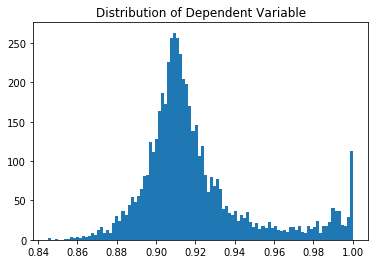

In [52]:
# Explore distribution of target
plt.hist(train['Target'], bins = 100)
plt.title("Distribution of Dependent Variable")
plt.show()

In [53]:
# Split training set into X and y (removing first column containing IDs)
X_train = train.iloc[:, 1:-1]
y_train = train.iloc[:, -1]

In [54]:
# Define function to compute RMSE
def scoreRMSE(predictor, X, true_y):
    predictions = predictor.predict(X)
    return np.sqrt(mean_squared_error(predictions, true_y))

In [55]:
# Fit unregularized linear regression and see RMSE on training set
linReg = Lin_Reg()
linReg.fit(X_train, y_train)

print "Training RMSE: ", scoreRMSE(linReg, X_train, y_train)

Training RMSE:  0.026629420202763727


In [56]:
# Remove first column to make predictions
X_test = test.iloc[:, 1:]
X_test.head()

,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,Feat 10,...,Feat 232,Feat 233,Feat 235,Feat 243,Feat 246,Feat 247,Feat 248,Feat 249,Feat 250,Feat 251
0,0.999849,0.174118,0.999819,0.997841,1.333330e-01,2.000000e-01,6.664254e-18,3.198842e-17,-5.264760e-17,-6.297720e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,0.728471,0.054397,0.649,0.416164,5.399800e-02,0.667391
1,0.999958,0.164706,1.000000,0.996741,6.666700e-02,2.132561e-17,6.664254e-18,3.198842e-17,-5.264760e-17,-6.297720e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,0.497255,0.037736,0.375,0.165514,1.019730e-01,0.506650
2,0.999666,0.174118,0.999479,0.997376,1.332851e-16,2.132561e-17,6.664254e-18,3.198842e-17,-5.264760e-17,-6.297720e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,0.688941,0.019309,1.000,0.192069,1.207000e-01,0.498784
3,0.999735,0.174118,0.999655,0.997173,1.333330e-01,2.132561e-17,6.664254e-18,3.198842e-17,3.636360e-01,1.666670e-01,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,0.654118,0.019089,0.333,0.451252,1.641800e-01,0.774466
4,0.999806,0.164706,0.999551,0.997234,1.332851e-16,2.132561e-17,6.664254e-18,3.198842e-17,-5.264760e-17,-6.297720e-17,...,-8.463602e-17,3.465412e-17,-3.998552e-18,7.997105e-18,0.627451,0.160433,0.882,0.147407,-3.432091e-17,0.481240


In [57]:
# Make predictions using linear regression model fitted above
predictions = linReg.predict(X_test)

In [58]:
# Format predictions to be compatible with Kaggle upload
sample_submission = pd.DataFrame(data=predictions, columns=['Predicted'])
sample_submission.insert(0, "Id", range(1, 1 + X_test.shape[0]))
sample_submission['Id'] = sample_submission['Id'].astype(str)
sample_submission.head()

,Id,Predicted
0,1,0.927214
1,2,0.921886
2,3,0.925324
3,4,0.925848
4,5,0.924586


In [59]:
# Save predictions to .csv file for upload to Kaggle
sample_submission.to_csv("sample_submission.csv", index=False)

In [60]:
def train_val_test_split(train, train_size=0.6, val=0.2):
    train_set, test_val_set = train_test_split(train.drop('Id', axis=1), test_size=1-train_size)
    test_set, val_set = train_test_split(test_val_set, test_size=float(val)/(1-train_size))
    train_set_X = train_set.drop(['Target'], axis=1)
    train_set_Y = train_set['Target']
    val_set_X = val_set.drop(['Target'], axis=1)
    val_set_Y = val_set['Target']
    test_set_X = test_set.drop(['Target'], axis=1)
    test_set_Y = test_set['Target']
    return train_set_X, train_set_Y, val_set_X, val_set_Y, test_set_X, test_set_Y
train_set_X, train_set_Y, val_set_X, val_set_Y, test_set_X, test_set_Y = train_val_test_split(train)

In [61]:
linReg = Lin_Reg()
linReg.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(linReg, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(linReg, val_set_X, val_set_Y)

Training RMSE:  0.026868250564596883
Validation RMSE:  0.02696039876005351


In [62]:
# Basis Functions
def apply_basis(train_set, funcs):
    train_set = train_set.copy()
    basis_train = pd.DataFrame()
    for column in train_set.columns:
        if column == 'Target' or column == 'Id':
            basis_train[column] = train_set[column]
            continue
        for i in range(0,len(funcs)):
            basis_train[column] = train_set[column]
            func = np.vectorize(funcs[i])
            basis_train[column + "_func_" + str(i)] = func(train_set[column])
    return basis_train

In [63]:
poly_funcs = [lambda x: x ** i for i in range(2,5)]
basis_train = apply_basis(train, poly_funcs)

In [64]:
train_set_X, train_set_Y, val_set_X, val_set_Y, test_set_X, test_set_Y = train_val_test_split(basis_train)

In [65]:
# Linear Regression with Polynomial Basis Function (no regularization)
linReg = Lin_Reg()
linReg.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(linReg, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(linReg, val_set_X, val_set_Y)

Training RMSE:  0.025460135897892346
Validation RMSE:  9546820.122044556


In [66]:
# Linear Regression with Lasso Regularization + Polynomial Basis Function
lasso = LassoCV()
lasso.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(lasso, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(lasso, val_set_X, val_set_Y)

Training RMSE:  0.027898439154878687
Validation RMSE:  0.028345996696672864


In [67]:
if turn_on_feature_selection:
    train_set_X = train_set_X[columns]
    val_set_X = val_set_X[columns]

In [68]:
# Linear Regression with Ridge Regularization + Polynomial Basis Function
ridge = RidgeCV()
ridge.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(ridge, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(ridge, val_set_X, val_set_Y)

Training RMSE:  0.025446697979725836
Validation RMSE:  0.042566440366663974


In [77]:
# Random Forest Regression + Polynomial Basis Function
forest = RandomForestRegressor(n_estimators=2500)
forest.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(forest, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(forest, val_set_X, val_set_Y)

Training RMSE:  0.010138955473596613
Validation RMSE:  0.027465421310722257


In [70]:
# Elastic Net Regression + Polynomial Basis Function
elastic = ElasticNetCV()
elastic.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(elastic, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(elastic, val_set_X, val_set_Y)

Training RMSE:  0.027898439154878687
Validation RMSE:  0.028345996696672864


In [71]:
# XGBoost + Polynomial Basis Function + Feature Selection via Lasso
xgb = XGBRegressor()
xgb.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(xgb, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(xgb, val_set_X, val_set_Y)

Training RMSE:  0.02445129628665152
Validation RMSE:  0.02760781684748522


In [72]:
# AdaBoost Regression w/ Random Forest base model + Polynomial Basis Function
ada = AdaBoostRegressor(n_estimators=300)
ada.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(ada, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(ada, val_set_X, val_set_Y)

Training RMSE:  0.028533342977046863
Validation RMSE:  0.028961778204356175


In [ ]:
bagging = BaggingRegressor(DecisionTreeRegressor(), n_estimators=1000)
bagging.fit(train_set_X, train_set_Y)
print "Training RMSE: ", scoreRMSE(bagging, train_set_X, train_set_Y)
print "Validation RMSE: ", scoreRMSE(bagging, val_set_X, val_set_Y)

In [36]:
def to_kaggle(model, test):
    df = pd.DataFrame()
    df['Id'] = range(1,3555)
    if 'Id' in test:
        df['Predicted'] = model.predict(test.drop('Id', axis=1))
    else:
        df['Predicted'] = model.predict(test)
    return df

In [ ]:
final_lasso = LassoCV()
final_lasso.fit(apply_basis(train, poly_funcs).drop(['Id','Target'], axis=1), y_train)
kaggle_lasso = to_kaggle(final_lasso, apply_basis(test, poly_funcs))

In [ ]:
with open('submission_lasso.csv', 'w') as out:
    out.write(kaggle_lasso.to_csv(index=False))

In [ ]:
final_ridge = RidgeCV()
final_ridge.fit(apply_basis(train, poly_funcs).drop(['Id','Target'], axis=1), y_train)
kaggle_ridge = to_kaggle(final_ridge, apply_basis(test, poly_funcs))

In [ ]:
with open('submission_ridge.csv', 'w') as out:
    out.write(kaggle_ridge.to_csv(index=False))

In [ ]:
final_elastic = ElasticNetCV()
final_elastic.fit(apply_basis(train, poly_funcs).drop(['Id','Target'], axis=1), y_train)
kaggle_elastic = to_kaggle(final_elastic, apply_basis(test, poly_funcs))

In [ ]:
with open('submission_elastic.csv', 'w') as out:
    out.write(kaggle_elastic.to_csv(index=False))

In [ ]:
final_forest = RandomForestRegressor()
final_forest.fit(apply_basis(train, poly_funcs).drop(['Id','Target'], axis=1), y_train)
kaggle_forest = to_kaggle(final_forest, apply_basis(test, poly_funcs))

In [ ]:
with open('submission_forest.csv', 'w') as out:
    out.write(kaggle_forest.to_csv(index=False))

In [ ]:
def eval_model(model):
#     clf = model()
    model.fit(train_set_X, train_set_Y)
    print "Training RMSE: ", scoreRMSE(model, train_set_X, train_set_Y)
    print "Validation RMSE: ", scoreRMSE(model, val_set_X, val_set_Y)

In [ ]:
final_lasso = LassoCV()
final_lasso.fit(apply_basis(train, poly_funcs).drop(['Id','Target'], axis=1), y_train)
kaggle_lasso = to_kaggle(final_lasso, apply_basis(test, poly_funcs))

In [ ]:
with open('submission_lasso.csv', 'w') as out:
    out.write(kaggle_lasso.to_csv(index=False))

In [75]:
final_xgb = XGBRegressor()
final_xgb.fit(apply_basis(train.drop(['Id','Target'], axis=1), poly_funcs), y_train)
kaggle_xgb = to_kaggle(final_xgb, apply_basis(test, poly_funcs))

In [76]:
with open('submission_XGB.csv', 'w') as out:
    out.write(kaggle_xgb.to_csv(index=False))

In [ ]:
final_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=12), n_estimators=200)
final_ada.fit(apply_basis(train, poly_funcs).drop(['Id','Target'], axis=1), y_train)
kaggle_ada = to_kaggle(final_ada, apply_basis(test, poly_funcs))

In [ ]:
with open('submission_ada.csv', 'w') as out:
    out.write(kaggle_ada.to_csv(index=False))